ERROR: Invalid requirement: '#'


In [2]:
#Import dependencies
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import find_peaks


In [3]:
# Set pandas display options
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
#Define Functions

# Define RSI function
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Define Bollinger Band function
def calculate_bollinger_bands(data, window=20):
    sma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return upper_band, lower_band

# Function to calculate daily volatility
def calculate_daily_volatility(prices):
    returns = prices.pct_change(fill_method=None)
    volatility = returns.rolling(window=21).std() * np.sqrt(252)  # Annualized daily volatility
    return volatility

# Function to calculate trade Action to do
def calculate_signals(today_to_tomorrow, yesterday_to_today):
    """
    Calculate the primary trading signals based on price differences.
    """
    conditions = [
        (today_to_tomorrow == 1) & (yesterday_to_today == -1),  # Buy signal: rising tomorrow, falling today
        (today_to_tomorrow == 1) & (yesterday_to_today == 1),   # Hold signal: rising tomorrow and today
        (today_to_tomorrow == 0) & (yesterday_to_today == 1),   # Hold signal: no change tomorrow, rising today
        (today_to_tomorrow == 1) & (yesterday_to_today == 0),   # Hold signal: rising tomorrow, no change today
        (today_to_tomorrow == -1) & (yesterday_to_today == 1),  # Sell signal: falling tomorrow, rising today
        (today_to_tomorrow == -1) & (yesterday_to_today == -1), # Short signal: falling tomorrow and today
        (today_to_tomorrow == 0) & (yesterday_to_today == -1),  # Short signal: no change tomorrow, falling today
        (today_to_tomorrow == -1) & (yesterday_to_today == 0)   # Short signal: falling tomorrow, no change today
    ]
    choices = ["buy", "hold", "hold", "hold", "sell", "short", "short", "short"]
    
    initial_actions = pd.Series(
        np.select(conditions, choices, default=pd.NA),
        index=today_to_tomorrow.index
    )
    return initial_actions

def handle_neutral_cases(actions, today_to_tomorrow, yesterday_to_today):
    """
    Handle neutral cases where both today-to-tomorrow and yesterday-to-today differences are zero.
    This function updates the action based on the previous action.
    """
    neutral_mask = (today_to_tomorrow == 0) & (yesterday_to_today == 0)
    prev_actions = actions.shift(1)

    actions.loc[neutral_mask] = np.where(
        prev_actions.loc[neutral_mask].isin(["buy", "hold"]),
        "hold",
        np.where(prev_actions.loc[neutral_mask].isin(["short", "sell"]), "short", pd.NA)
    )
    
    return actions

def generate_trading_signals(data):
    """
    Generate trading signals by first calculating primary signals and then handling neutral cases.
    """
    # Shift the data to get the price differences
    next_day = data.shift(-1)
    prev_day = data.shift(1)

    # Calculate the difference between today's and tomorrow's prices and yesterday's and today's prices
    today_to_tomorrow = np.sign(next_day - data)
    yesterday_to_today = np.sign(data - prev_day)

    # Part 1: Calculate primary signals
    actions = calculate_signals(today_to_tomorrow, yesterday_to_today)

    # Part 2: Handle neutral cases
    actions = handle_neutral_cases(actions, today_to_tomorrow, yesterday_to_today)

    return actions

In [5]:
# Fetch S&P 500 tickers
#Define dates
start_date = '2020-10-01'
end_date = '2024-10-18'

#Get tickers from wikipedia
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

# Filter out Class B shares that have a '.B' in the ticker name
sp500_tickers = [ticker for ticker in sp500_tickers if '.B' not in ticker]

print(f"Initial total S&P 500 tickers: {len(sp500_tickers)}")

Initial total S&P 500 tickers: 501


In [6]:
# Download historical prices
data = yf.download(sp500_tickers, start=start_date, end=end_date)['Adj Close']

# Fill NaN values with 0
data.fillna(0, inplace=True)

# Check if data was downloaded for all tickers
print(f"Successfully downloaded tickers: {len(data.columns)} out of {len(sp500_tickers)}")

[*********************100%***********************]  501 of 501 completed

Successfully downloaded tickers: 501 out of 501


In [7]:
# Display data Frame
data.head(15)

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00+00:00,98.455,114.132,73.216,0.000,100.803,29.400,211.759,499.510,110.816,42.213,...,198.786,24.324,70.923,62.116,27.635,78.819,85.300,129.334,258.480,159.083
2020-10-02 00:00:00+00:00,97.278,110.448,72.359,0.000,98.817,29.700,209.144,478.990,106.178,42.340,...,198.341,24.594,72.035,62.204,27.510,80.605,88.412,129.673,258.810,158.617
2020-10-05 00:00:00+00:00,100.484,113.849,73.880,0.000,100.728,30.640,210.169,486.470,108.590,43.282,...,198.843,25.118,72.674,63.078,28.144,82.409,87.408,133.346,268.010,158.520
2020-10-06 00:00:00+00:00,99.032,110.585,72.166,0.000,98.585,30.180,207.216,478.980,107.603,43.119,...,197.811,24.493,73.137,63.943,27.852,82.590,85.392,132.865,269.970,156.648
2020-10-07 00:00:00+00:00,101.224,112.461,73.157,0.000,99.968,30.240,210.132,493.150,110.518,43.762,...,199.770,24.941,73.865,63.625,27.944,84.204,87.213,136.397,276.580,155.087
2020-10-08 00:00:00+00:00,101.497,112.354,73.384,0.000,100.710,31.500,212.163,490.840,112.073,44.251,...,199.723,25.566,73.137,63.996,29.412,85.760,88.635,138.120,279.090,158.249
2020-10-09 00:00:00+00:00,103.056,114.308,73.686,0.000,101.740,31.530,215.901,502.160,114.858,44.360,...,200.073,24.772,71.513,64.172,28.978,86.486,88.709,139.373,284.000,160.440
2020-10-12 00:00:00+00:00,102.735,121.569,74.207,0.000,103.039,31.710,217.695,510.890,117.447,45.284,...,205.362,25.093,72.930,64.976,28.886,87.708,89.164,140.465,288.250,163.466
2020-10-13 00:00:00+00:00,102.725,118.344,73.796,0.000,100.552,30.810,216.553,514.310,115.100,44.233,...,201.123,24.763,70.598,64.428,28.544,85.817,89.192,136.378,286.730,160.334


In [8]:
# Display tickers that were successfully downloaded
downloaded_tickers = data.columns.get_level_values(0).unique()
print(f"Successfully downloaded tickers: {len(downloaded_tickers)} out of {len(sp500_tickers)}")

Successfully downloaded tickers: 501 out of 501


In [9]:
# Calculate various indicators
returns = data.pct_change()
daily_volatility = data.apply(calculate_daily_volatility)
rsi = data.apply(calculate_rsi)
sma_50 = data.rolling(window=50).mean()
sma_100 = data.rolling(window=100).mean()
sma_200 = data.rolling(window=200).mean()
upper_band, lower_band = calculate_bollinger_bands(data)
support = data.rolling(window=50).min()
resistance = data.rolling(window=50).max()
actions = data.apply(generate_trading_signals)

In [10]:
# Align data lengths by filling forward and backward
returns.ffill(inplace=True)
returns.bfill(inplace=True)
daily_volatility.ffill(inplace=True)
daily_volatility.bfill(inplace=True)
rsi.ffill(inplace=True)
rsi.bfill(inplace=True)
sma_50.ffill(inplace=True)
sma_50.bfill(inplace=True)
sma_100.ffill(inplace=True)
sma_100.bfill(inplace=True)
sma_200.ffill(inplace=True)
sma_200.bfill(inplace=True)
upper_band.ffill(inplace=True)
upper_band.bfill(inplace=True)
lower_band.ffill(inplace=True)
lower_band.bfill(inplace=True)
support.ffill(inplace=True)
support.bfill(inplace=True)
resistance.ffill(inplace=True)
resistance.bfill(inplace=True)
actions.ffill(inplace=True)
actions.bfill(inplace=True)

In [19]:
lower_band

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00+00:00,97.907,108.014,69.560,0.000,98.182,28.971,203.654,464.195,106.422,42.024,...,188.261,23.458,67.993,61.876,26.743,80.291,84.914,126.692,259.257,153.404
2020-10-02 00:00:00+00:00,97.907,108.014,69.560,0.000,98.182,28.971,203.654,464.195,106.422,42.024,...,188.261,23.458,67.993,61.876,26.743,80.291,84.914,126.692,259.257,153.404
2020-10-05 00:00:00+00:00,97.907,108.014,69.560,0.000,98.182,28.971,203.654,464.195,106.422,42.024,...,188.261,23.458,67.993,61.876,26.743,80.291,84.914,126.692,259.257,153.404
2020-10-06 00:00:00+00:00,97.907,108.014,69.560,0.000,98.182,28.971,203.654,464.195,106.422,42.024,...,188.261,23.458,67.993,61.876,26.743,80.291,84.914,126.692,259.257,153.404
2020-10-07 00:00:00+00:00,97.907,108.014,69.560,0.000,98.182,28.971,203.654,464.195,106.422,42.024,...,188.261,23.458,67.993,61.876,26.743,80.291,84.914,126.692,259.257,153.404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-11 00:00:00+00:00,136.509,217.706,189.543,119.659,110.437,109.627,327.664,486.983,221.468,56.534,...,284.892,32.436,71.135,62.107,110.301,131.961,128.389,101.650,350.045,187.144
2024-10-14 00:00:00+00:00,137.241,219.472,189.547,121.735,110.493,109.439,327.219,486.980,221.624,56.370,...,284.886,32.455,72.944,62.006,111.024,131.944,128.394,101.593,354.386,187.130
2024-10-15 00:00:00+00:00,138.073,221.275,189.541,122.914,110.738,108.595,328.398,486.752,221.700,56.195,...,284.840,32.440,74.920,61.964,111.673,132.029,128.499,101.512,356.245,187.202


In [11]:
print(f"Returns shape: {returns.shape}")
print(returns.head())

print(f"Daily Volatility shape: {daily_volatility.shape}")
print(daily_volatility.head())

print(f"RSI shape: {rsi.shape}")
print(rsi.head())

print(f"SMA_50 shape: {sma_50.shape}")
print(sma_50.head())

print(f"SMA_100 shape: {sma_100.shape}")
print(sma_100.head())

print(f"SMA_200 shape: {sma_200.shape}")
print(sma_200.head())

print(f"Upper Band shape: {upper_band.shape}")
print(upper_band.head())

print(f"Lower Band shape: {lower_band.shape}")
print(lower_band.head())

print(f"Support shape: {support.shape}")
print(support.head())

print(f"Resistance shape: {resistance.shape}")
print(resistance.head())

print(f"Action shape: {actions.shape}")
print(actions.head())

Returns shape: (1018, 501)
Ticker                         A   AAPL   ABBV  ABNB    ABT   ACGL    ACN  \
Date                                                                        
2020-10-01 00:00:00+00:00 -0.012 -0.032 -0.012   inf -0.020  0.010 -0.012   
2020-10-02 00:00:00+00:00 -0.012 -0.032 -0.012   inf -0.020  0.010 -0.012   
2020-10-05 00:00:00+00:00  0.033  0.031  0.021   inf  0.019  0.032  0.005   
2020-10-06 00:00:00+00:00 -0.014 -0.029 -0.023   inf -0.021 -0.015 -0.014   
2020-10-07 00:00:00+00:00  0.022  0.017  0.014   inf  0.014  0.002  0.014   

Ticker                      ADBE    ADI    ADM  ...    WTW     WY  WYNN  \
Date                                            ...                       
2020-10-01 00:00:00+00:00 -0.041 -0.042  0.003  ... -0.002  0.011 0.016   
2020-10-02 00:00:00+00:00 -0.041 -0.042  0.003  ... -0.002  0.011 0.016   
2020-10-05 00:00:00+00:00  0.016  0.023  0.022  ...  0.003  0.021 0.009   
2020-10-06 00:00:00+00:00 -0.015 -0.009 -0.004  ... -0.005

In [12]:
print(f"Return Length: {len(returns)}")
print(f"Data Length: {len(data.index)}")
print(f"Volatility Length: {len(daily_volatility)}")
print(f"RSI Length: {len(rsi)}")
print(f"SMA_50 Length: {len(sma_50)}")
print(f"SMA_100 Length: {len(sma_100)}")
print(f"SMA_200 Length: {len(sma_200)}")
print(f"Upper Band Length: {len(upper_band)}")
print(f"Lower Band Length: {len(lower_band)}")
print(f"Support Length: {len(support)}")
print(f"Resistance Length: {len(resistance)}")
print(f"Action Length: {len(actions)}")

Return Length: 1018
Data Length: 1018
Volatility Length: 1018
RSI Length: 1018
SMA_50 Length: 1018
SMA_100 Length: 1018
SMA_200 Length: 1018
Upper Band Length: 1018
Lower Band Length: 1018
Support Length: 1018
Resistance Length: 1018
Action Length: 1018


In [13]:
# Compile indicators into a single DataFrame
length = len(data) * len(data.columns)
indicators_df = pd.DataFrame({
    'Date': np.repeat(data.index, len(data.columns)),
    'Ticker': np.tile(data.columns, len(data)),
    'Adjusted Close': data.values.flatten(),
    'Return': returns.values.flatten(),
    'Volatility': daily_volatility.values.flatten(),
    'RSI': rsi.values.flatten(),
    'SMA_50': sma_50.values.flatten(),
    'SMA_100': sma_100.values.flatten(),
    'SMA_200': sma_200.values.flatten(),
    'Upper Band': upper_band.values.flatten(),
    'Lower Band': lower_band.values.flatten(),
    'Support': support.values.flatten(),
    'Resistance': resistance.values.flatten(),
    'Action': actions.values.flatten(),
})

# Replace inf values with NaN using an assignment
indicators_df['Return'] = indicators_df['Return'].replace([np.inf, -np.inf], np.nan)

# Drop NaN values
indicators_df.dropna(subset=['Adjusted Close', 'Return', 'Volatility', 'RSI', 'SMA_50', 'SMA_100', 'SMA_200', 'Upper Band', 'Lower Band', 'Support', 'Resistance', 'Action'], inplace=True)

# Display DataFrame
print(indicators_df.head())

                       Date Ticker  Adjusted Close  Return  Volatility    RSI  \
0 2020-10-01 00:00:00+00:00      A          98.455  -0.012       0.252 66.581   
1 2020-10-01 00:00:00+00:00   AAPL         114.132  -0.032       0.449 51.119   
2 2020-10-01 00:00:00+00:00   ABBV          73.216  -0.012       0.292 42.934   
4 2020-10-01 00:00:00+00:00    ABT         100.803  -0.020       0.265 50.214   
5 2020-10-01 00:00:00+00:00   ACGL          29.400   0.010       0.375 56.847   

   SMA_50  SMA_100  SMA_200  Upper Band  Lower Band  Support  Resistance  \
0 105.846  112.824  122.027     105.608      97.907   97.278     115.772   
1 115.055  122.170  124.556     120.359     108.014  106.295     121.759   
2  79.693   85.449   91.222      75.184      69.560   68.549      92.549   
4 101.303  104.435  107.231     102.941      98.182   97.750     106.520   
5  32.238   33.417   36.128      32.184      28.971   29.210      35.300   

  Action  
0    buy  
1    buy  
2    buy  
4    buy  
5

In [14]:
indicators_df.head()

,Date,Ticker,Adjusted Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action
0,2020-10-01 00:00:00+00:00,A,98.455,-0.012,0.252,66.581,105.846,112.824,122.027,105.608,97.907,97.278,115.772,buy
1,2020-10-01 00:00:00+00:00,AAPL,114.132,-0.032,0.449,51.119,115.055,122.170,124.556,120.359,108.014,106.295,121.759,buy
2,2020-10-01 00:00:00+00:00,ABBV,73.216,-0.012,0.292,42.934,79.693,85.449,91.222,75.184,69.560,68.549,92.549,buy
4,2020-10-01 00:00:00+00:00,ABT,100.803,-0.020,0.265,50.214,101.303,104.435,107.231,102.941,98.182,97.750,106.520,buy
5,2020-10-01 00:00:00+00:00,ACGL,29.400,0.010,0.375,56.847,32.238,33.417,36.128,32.184,28.971,29.210,35.300,hold


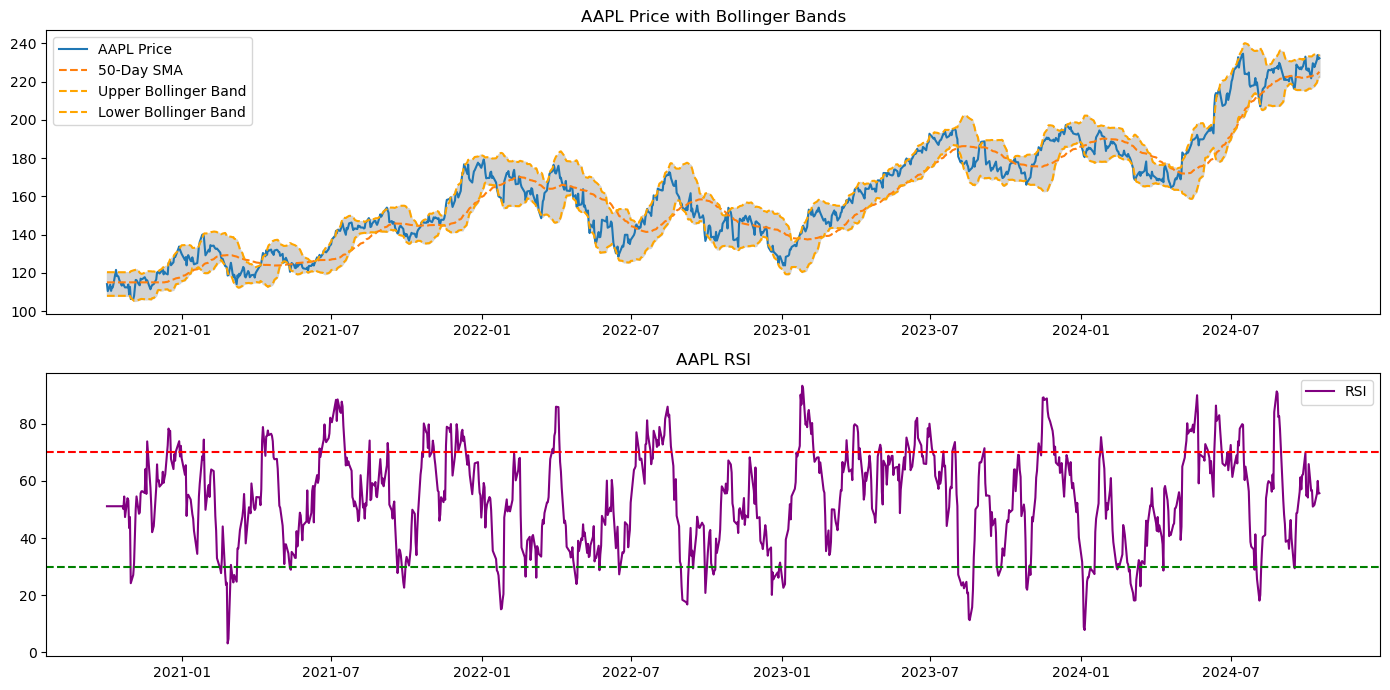

In [15]:
# Plot RSI and Bollinger Bands for a sample stock (e.g., AAPL)
ticker_sample = 'AAPL'
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data[ticker_sample], label=f'{ticker_sample} Price')
plt.plot(sma_50[ticker_sample], label='50-Day SMA', linestyle='--')
plt.plot(upper_band[ticker_sample], label='Upper Bollinger Band', linestyle='--', color='orange')
plt.plot(lower_band[ticker_sample], label='Lower Bollinger Band', linestyle='--', color='orange')
plt.fill_between(data.index, lower_band[ticker_sample], upper_band[ticker_sample], color='lightgray')
plt.legend()
plt.title(f'{ticker_sample} Price with Bollinger Bands')
plt.subplot(2, 1, 2)
plt.plot(rsi[ticker_sample], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.legend()
plt.title(f'{ticker_sample} RSI')
plt.tight_layout()
plt.show()

In [16]:
# Prepare data for plotting
ticker_sample = 'AAPL'
data_sample = data[[ticker_sample]].copy()
data_sample['SMA_50'] = sma_50[ticker_sample]
data_sample['SMA_100'] = sma_100[ticker_sample]
data_sample['SMA_200'] = sma_200[ticker_sample]
data_sample['RSI'] = rsi[ticker_sample]
data_sample['Support'] = support[ticker_sample]
data_sample['Resistance'] = resistance[ticker_sample]

# Plot
price_plot = data_sample.hvplot.line(y=[ticker_sample, 'SMA_50', 'SMA_100', 'SMA_200'], title=f'{ticker_sample} Price with Bollinger Bands, SMA, and Resistance Levels', ylabel='Price')
support_resistance_plot = data_sample.hvplot.line(y=['Support', 'Resistance'], line_dash='dashed', color=['green', 'red'])
rsi_plot = data_sample.hvplot.line(y='RSI', title=f'{ticker_sample} RSI', ylabel='RSI').opts(yformatter='%.0f') * hv.HLine(70).opts(color='red', line_dash='dashed') * hv.HLine(30).opts(color='green', line_dash='dashed')

(price_plot * support_resistance_plot + rsi_plot).cols(1)


:Layout
   .Overlay.I  :Overlay
      .NdOverlay.I  :NdOverlay   [Ticker]
         :Curve   [Date]   (value)
      .NdOverlay.II :NdOverlay   [Ticker]
         :Curve   [Date]   (value)
   .Overlay.II :Overlay
      .Curve.I  :Curve   [Date]   (RSI)
      .HLine.I  :HLine   [x,y]
      .HLine.II :HLine   [x,y]

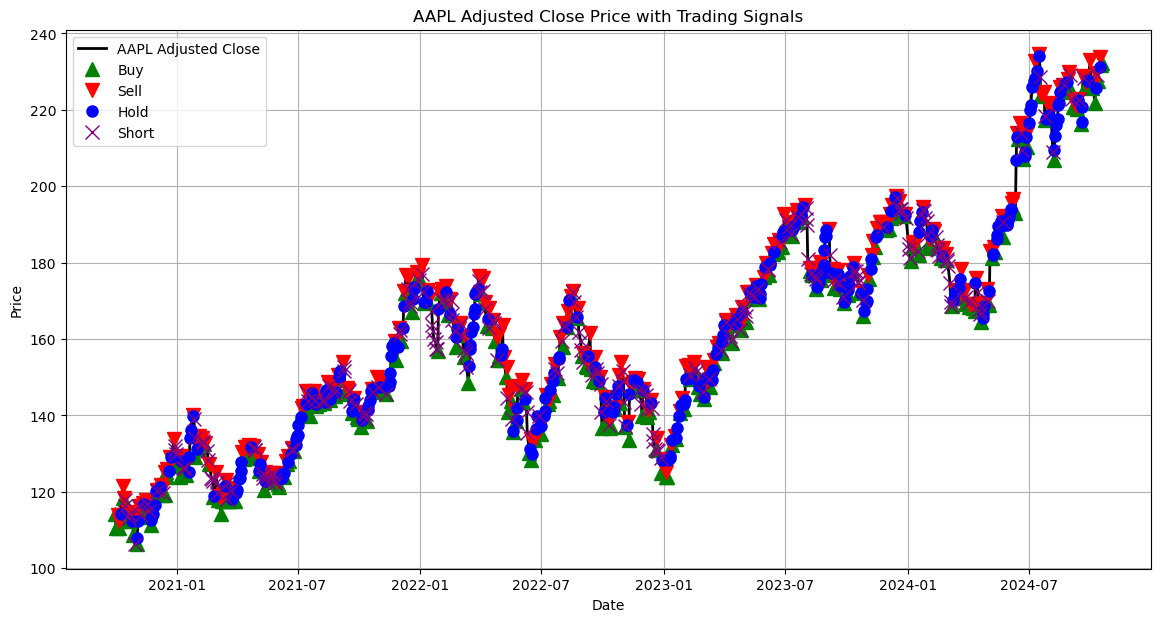

In [17]:
# %% Plot the trading signals for AAPL

ticker_sample = 'AAPL'

# Extract the price data and actions for AAPL
price_data = data[ticker_sample]
actions_aapl = actions[ticker_sample]

# Define marker styles for each action
marker_styles = {
    'buy': {'marker': '^', 'color': 'green', 'label': 'Buy', 'markersize': 10},
    'sell': {'marker': 'v', 'color': 'red', 'label': 'Sell', 'markersize': 10},
    'hold': {'marker': 'o', 'color': 'blue', 'label': 'Hold', 'markersize': 8},
    'short': {'marker': 'x', 'color': 'purple', 'label': 'Short', 'markersize': 10}
}

# Plot the stock price
plt.figure(figsize=(14, 7))
plt.plot(price_data, label=f'{ticker_sample} Adjusted Close', color='black', lw=2)

# Plot the markers for actions
for action, style in marker_styles.items():
    action_mask = actions_aapl == action
    plt.plot(price_data.index[action_mask], price_data[action_mask], 
             style['marker'], color=style['color'], label=style['label'], markersize=style['markersize'])

# Add titles, labels, and legends
plt.title(f'{ticker_sample} Adjusted Close Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# %% Plot the trading signals for AAPL using hvPlot

ticker_sample = 'AAPL'

# Prepare the price data and actions for AAPL
price_data = data[[ticker_sample]].copy()
price_data['Action'] = actions[ticker_sample]

# Define marker styles for each action
action_colors = {'buy': 'green', 'sell': 'red', 'hold': 'blue', 'short': 'purple'}

# Create a base line plot for the adjusted close price
price_plot = price_data.hvplot.line(
    y=ticker_sample, 
    title=f'{ticker_sample} Adjusted Close Price with Trading Signals',
    ylabel='Price', 
    line_width=2,
    height=400,
    width=800,
    legend=False
)

# Overlay the action markers
buy_markers = price_data[price_data['Action'] == 'buy'].hvplot.scatter(
    y=ticker_sample, marker='^', color=action_colors['buy'], size=10, label='Buy'
)
sell_markers = price_data[price_data['Action'] == 'sell'].hvplot.scatter(
    y=ticker_sample, marker='v', color=action_colors['sell'], size=10, label='Sell'
)
hold_markers = price_data[price_data['Action'] == 'hold'].hvplot.scatter(
    y=ticker_sample, marker='o', color=action_colors['hold'], size=6, label='Hold'
)
short_markers = price_data[price_data['Action'] == 'short'].hvplot.scatter(
    y=ticker_sample, marker='x', color=action_colors['short'], size=10, label='Short'
)

# Combine the price plot and the markers
interactive_plot = price_plot * buy_markers * sell_markers * hold_markers * short_markers

# Display the interactive plot with zoom functionality
interactive_plot.opts(legend_position='top_left')
interactive_plot


:Overlay
   .Curve.I       :Curve   [Date]   (AAPL)
   .Scatter.Buy   :Scatter   [Date]   (AAPL)
   .Scatter.Sell  :Scatter   [Date]   (AAPL)
   .Scatter.Hold  :Scatter   [Date]   (AAPL)
   .Scatter.Short :Scatter   [Date]   (AAPL)